In [36]:
import os
os.environ['PYOPENGL_PLATFORM']='osmesa'

import argparse
import pickle
import sys
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
# from gta_utils import LIMBS, read_depthmap
# from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
# from utils import *
import copy
import argparse

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import sys
sys.path.append('../')
sys.path.append('../../src')

from benji_prox_dataloader import *
from visualisation import *
import tqdm
from simple_transformer import PoseTransformer
import torch
from torch import nn



In [4]:

root_dir = "/cluster/scratch/bdayan/prox_data/"

smplx_model_path='/cluster/home/bdayan/prox/prox/models_smplx_v1_1/models/'
in_frames=15
pred_frames=30
frame_jump=5
window_overlap_factor=5
lr = 0.0001
n_iter = 100

pd = proxDatasetJoints(root_dir=root_dir + '/PROXD', in_frames=in_frames, pred_frames=pred_frames, \
                       output_type='joint_locations', smplx_model_path=smplx_model_path, frame_jump=5)
pdc = DatasetBase(root_dir=root_dir + '/recordings', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='Color', extra_prefix='', frame_jump=5)

print(len(pd), len(pdc))
pd.align(pdc)
pdc.align(pd)
print(len(pd), len(pdc))

# pdi = proxDatasetImages(root_dir="/cluster/scratch/bdayan/prox_data/recordings", in_frames=in_frames, pred_frames=pred_frames)

# dataloader = DataLoader(pd, batch_size=batch_size,
#                         shuffle=True, num_workers=0, collate_fn=my_collate)

702 809
711 711


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [48]:
a = torch.Tensor([1.0, 2.3])
a
a.device

tensor([1.0000, 2.3000])

device(type='cpu')

In [49]:
gru = PoseGRU_inputFC2(input_size=(25,3))


In [55]:
gru.input_fc.to(device)

Linear(in_features=75, out_features=512, bias=True)

In [58]:
help(gru.input_fc.to)

Help on method to in module torch.nn.modules.module:

to(*args, **kwargs) method of torch.nn.modules.linear.Linear instance
    Moves and/or casts the parameters and buffers.
    
    This can be called as
    
    .. function:: to(device=None, dtype=None, non_blocking=False)
    
    .. function:: to(dtype, non_blocking=False)
    
    .. function:: to(tensor, non_blocking=False)
    
    .. function:: to(memory_format=torch.channels_last)
    
    Its signature is similar to :meth:`torch.Tensor.to`, but only accepts
    floating point desired :attr:`dtype` s. In addition, this method will
    only cast the floating point parameters and buffers to :attr:`dtype`
    (if given). The integral parameters and buffers will be moved
    :attr:`device`, if that is given, but with dtypes unchanged. When
    :attr:`non_blocking` is set, it tries to convert/move asynchronously
    with respect to the host if possible, e.g., moving CPU Tensors with
    pinned memory to CUDA devices.
    
    See 

In [38]:
import wandb
run_path = "benjidayan/vh-human-motion-pred/2gszpu3b"
api = wandb.Api()
run = api.run(run_path)
model = wandb.restore('saves/GRU_joints_15_30_3fps_22_05_1718_epoch0_bn39.pt', run_path=run_path)

In [42]:
df = run.history()

In [44]:
df

,_step,rep_pred_MSEloss,_runtime,MSEloss,_timestamp
0,0,0.168857,31,1.920232,1653232958
1,1,0.114864,50,0.844146,1653232977
2,2,0.296805,71,0.749383,1653232998
3,3,0.375953,91,0.716558,1653233018
4,4,0.231810,112,0.484986,1653233039
...,...,...,...,...,...
294,294,0.197386,6057,0.191731,1653238984
295,295,0.088551,6076,0.109932,1653239003
296,296,0.262320,6097,0.209607,1653239024
297,297,0.194018,6119,0.161211,1653239046


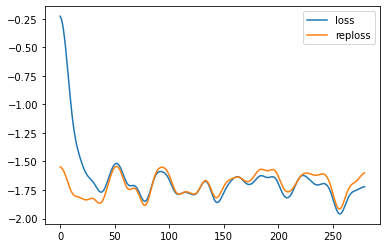

In [47]:
from scipy.ndimage import gaussian_filter1d
loss = df.MSEloss[df.MSEloss < 5.]
rep_loss = df.rep_pred_MSEloss[df.MSEloss < 5.]
loss2 = gaussian_filter1d(loss, sigma=5)
rep_loss2 = gaussian_filter1d(rep_loss, sigma=5)
plt.plot(np.log(loss2), label='loss')
plt.plot(np.log(rep_loss2), label='reploss')
plt.legend()

In [27]:
with open('saves/GRU_joints_15_30_3fps_22_05_1718_epoch0_bn39.pt', 'rb') as file:
    stuff = pickle.load(file)

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [23]:
model2 = torch.load(model, encoding='latin1')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 0: invalid start byte

In [21]:
dir(model)

['_CHUNK_SIZE',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_checkClosed',
 '_checkReadable',
 '_checkSeekable',
 '_checkWritable',
 '_finalizing',
 'buffer',
 'close',
 'closed',
 'detach',
 'encoding',
 'errors',
 'fileno',
 'flush',
 'isatty',
 'line_buffering',
 'mode',
 'name',
 'newlines',
 'read',
 'readable',
 'readline',
 'readlines',
 'reconfigure',
 'seek',
 'seekable',
 'tell',
 'truncate',
 'writable',
 'write',
 'write_through',
 'writelines']

In [18]:
a = torch.load('saves/GRU_joints_15_30_3fps_22_05_1718_epoch0_bn79.pt')

In [5]:
pd.output_type = 'joint_locations'
idx, in_joint_locations, pred_joint_locations = pd.__getitem__(500)
pd.output_type = 'raw_pkls'
(idx, (in_joint_fns, in_joint_data), (pred_joint_fns, pred_joint_data)) = pd.__getitem__(500)
in_frames_dicts, in_frames_fns, pred_frames_dicts, pred_frames_fns = pdc.__getitem__(500)

In [4]:
in_frames = [np.array(cv2.imread(fn)) for fn in in_frames_fns]

In [5]:
in_joint_fns

['/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01749__00.00.58.270/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01754__00.00.58.435/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01759__00.00.58.604/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01764__00.00.58.768/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01769__00.00.58.936/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01774__00.00.59.107/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01779__00.00.59.270/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01784__00.00.59.440/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD/MPH112_00034_01/results/s001_frame_01789__00.00.59.603/000.pkl',
 '/cluster/scratch/bdayan/prox_data/P

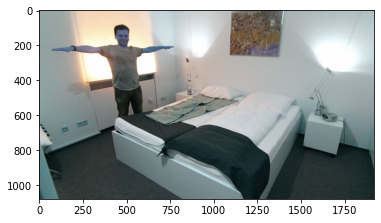

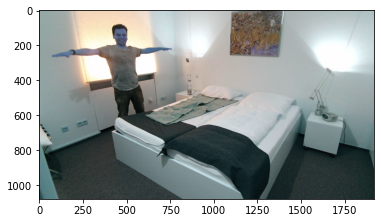

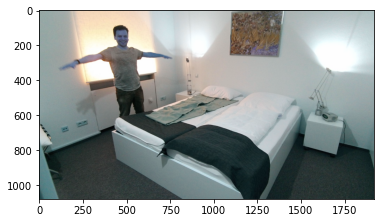

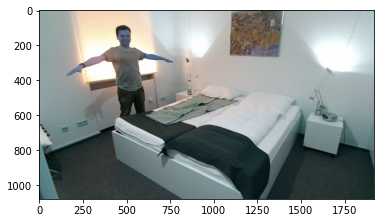

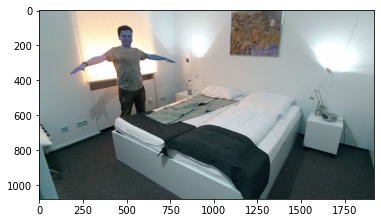

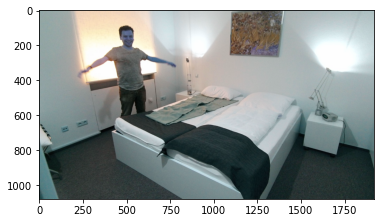

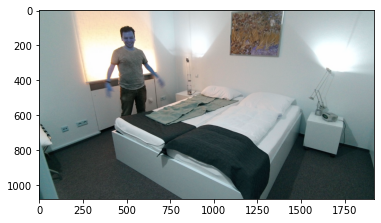

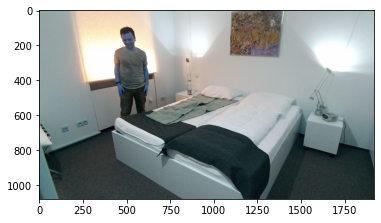

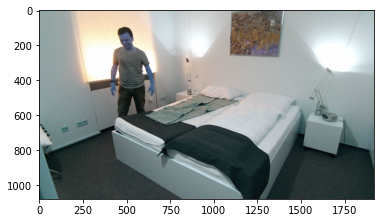

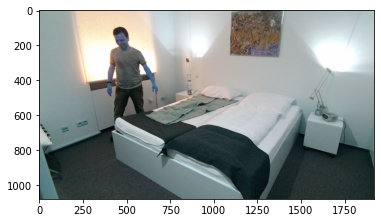

In [6]:
for img in in_frames:
    _ = plt.figure()
    _ = plt.imshow(img)

In [9]:
outputs = smplx_and_background_to_video(in_frames, in_joint_data, body_model=pd.body_model)

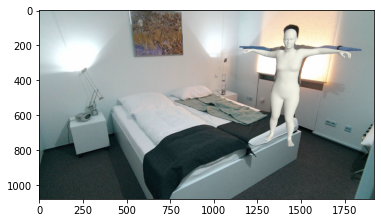

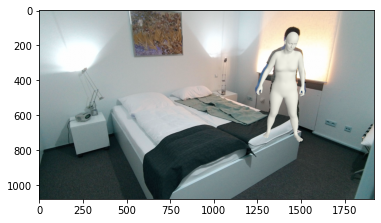

In [10]:
for im in [outputs[0], outputs[-1]]:
    _ = plt.figure()
    _ = plt.imshow(im)

In [11]:
from utils import *
pd.output_type='raw_pkls'
(idx, (in_frames_fns, in_data), (pred_frames_fns, pred_data)) = pd.__getitem__(500)
_betas, _body_pose, base_euler_angles, base_transl = extract_data(in_data[-1])

In [12]:
base_euler_angles

tensor([[-2.7733, -0.0070,  0.4914]])

In [ ]:
# from visualisation import *
# animate_skeleton(in_joint_locations.detach().numpy())

In [7]:
import pickle
with open('temp.pkl', 'wb') as file:
    pickle.dump([in_joint_data, in_joint_locations], file)

In [ ]:
skeleton_frames = in_joint_locations.detach().numpy()
trans = np.eye(4)
trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# trans[:3, -1] = np.array([0, 0, -3])
trans[:3, :3] = trans[:3, :3]@rz@rz@rz
trans[:3, -1] = np.array([5, 0, 3])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)

vis.add_geometry(mesh_frame)  

outs = []
for t in range(skeleton_frames.shape[0]):  
    print(t)
    vis.poll_events()
    vis.update_renderer()
    skeleton_input = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(skeleton_frames[t]),
        lines=o3d.utility.Vector2iVector(LIMBS))
    skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

    vis.add_geometry(skeleton_input)

    # ctr = vis.get_view_control()
    # cam_param = ctr.convert_to_pinhole_camera_parameters()
    # cam_param = update_cam(cam_param, trans)
    # ctr.convert_from_pinhole_camera_parameters(cam_param)

    vis.poll_events()
    vis.update_renderer()
    outs.append(np.asarray(vis.capture_screen_float_buffer()))
    vis.remove_geometry(skeleton_input)

True

In [ ]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  

vis.poll_events()
vis.update_renderer()
temp = vis.capture_screen_float_buffer(False)



True

In [4]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  

True

True

In [5]:
vis.poll_events()

True

In [ ]:
plt.imshow(np.asarray(temp))

In [ ]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame) 

vis.poll_events()
vis.update_renderer()

t=3

skeleton_frames = in_joint_locations.detach().numpy()
skeleton_input = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(skeleton_frames[t]),
    lines=o3d.utility.Vector2iVector(LIMBS))
skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

vis.add_geometry(skeleton_input)


vis.poll_events()
vis.update_renderer()
temp = vis.capture_screen_float_buffer(False)


True

In [ ]:
plt.imshow(temp)

In [5]:
skeleton_frames = in_joint_locations.detach().numpy()
trans = np.eye(4)
trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# trans[:3, -1] = np.array([0, 0, -3])
trans[:3, :3] = trans[:3, :3]@rz@rz@rz
trans[:3, -1] = np.array([5, 0, 3])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  
temp = vis.capture_screen_float_buffer(False)

False

In [6]:
vis.update_renderer()

In [ ]:
temp = vis.capture_screen_float_buffer(False)

In [8]:
base_euler_angles = in_data['global_orient']

NameError: name 'in_data' is not defined